In [1]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle

%matplotlib inline

In [38]:
class LaneDetection():
    def __init__(self, cameraMatrix, distCoeffs):
        
        self.src_pts = np.array([[155, 720], [600, 450], [700, 450], [1150, 720]])
        self.dst_pts = np.array([[300, 720], [300, 300], [900, 300], [900, 720]])
        self.src_pts_float = self.src_pts.astype(np.float32)
        self.dst_pts_float = self.dst_pts.astype(np.float32)
        
        self.ym_per_pix = 3/45
        self.xm_per_pix = 3.7/595
        
        self.cameraMatrix = cameraMatrix
        self.distCoeffs = distCoeffs
        
    def lane_filtering(self, img,
                  threshold_x=(10, 100), 
                  threshold_y=(20, 200), 
                  threshold_angle=(0.6, 1.5), 
                  threshold_mag=(40, 200),
                  threshold_s=(170, 255),
                  threshold_r=(230, 255)):
        self.img_in = img
        cameraMatrix = self.cameraMatrix
        distCoeffs = self.distCoeffs
        img = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
        channel_r = img[...,0]
        channel_s = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[...,2]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=7)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=7)
        grad_angle = np.arctan2(grad_y, grad_x)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        grad_x = np.uint8(255 * grad_x / grad_x.max())
        grad_y = np.uint8(255 * grad_y / grad_y.max())
        grad_mag = np.uint8(255 * grad_mag / grad_mag.max())

        (mask_x, mask_y, mask_angle, mask_angle1, mask_angle2, 
         mask_mag, mask_r, mask_s, mask_combined) = np.tile(np.zeros_like(grad_x), (9, 1, 1))
        mask_x[(grad_x>threshold_x[0])&(grad_x<threshold_x[1])] = 1
        mask_y[(grad_y>threshold_y[0])&(grad_y<threshold_y[1])] = 1
        mask_mag[(grad_mag>threshold_mag[0])&(grad_mag<threshold_mag[1])] = 1

        mask_angle1[(grad_angle>threshold_angle[0])&(grad_angle<threshold_angle[1])] = 1
        mask_angle2[(grad_angle>-threshold_angle[1])&(grad_angle<-threshold_angle[0])] = 1
        mask_angle[(mask_angle1 == 1) | (mask_angle2 == 1)] = 1

        mask_r[(channel_r>threshold_r[0])&(channel_r<threshold_r[1])] = 1
        mask_s[(channel_s>threshold_s[0])&(channel_s<threshold_s[1])] = 1


        mask_combined[((mask_r == 1) | (mask_s == 1)) | ( (mask_x == 1) & (mask_mag == 1))] = 1 
        masks = (mask_x, mask_y, mask_angle, mask_mag, mask_s, mask_r)
        img_channels = (grad_x, grad_y, grad_angle, grad_mag, channel_s, channel_r)

        return mask_combined, masks, img_channels
    
    def slice_center(self, img, slice_height):
        img = img.mean(axis=2)
        n_slices = img.shape[0]//slice_height
        x_centers = []
        y_centers = np.arange(img.shape[0]-1, 0, -slice_height)
        for y in y_centers:
            hist = img[y-slice_height:y,...].sum(axis=0)
            x_left = np.argmax(hist[:img.shape[1]//2,...])
            x_right = np.argmax(hist[img.shape[1]//2:,...]) + img.shape[1]//2
            x_centers.append((x_left, x_right))
        x_centers = np.array(x_centers)
        y_centers = np.tile(y_centers, (2, 1)).T

        return x_centers, y_centers
    
    def find_lane(self, img, width, height, stride):
        ksize = 20
        if len(img.shape) > 2:
            img = img.mean(axis=2)
        img = np.uint8(cv2.filter2D(img, cv2.CV_64F, np.ones((ksize, ksize))/ksize**2))
        img_out = np.tile(img, (3, 1, 1)).transpose((1, 2, 0)).astype(np.uint8)
        img_out = img_out.copy()
        hist_left = img[200:400,...].sum(axis=0)
        hist_right = img[800:1000,...].sum(axis=0)
        x_left = np.argmax(hist_left) + 200
        x_right = np.argmax(hist_right) + 800

        x_left_list = [x_left]
        x_right_list = [x_right]
        y_list = [img.shape[0]]

        y = y_list[0]+height//2
        pts_left = np.array([[x_left-width//2, y], 
                    [x_left-width//2, y-height], 
                    [x_left+width//2, y-height], 
                    [x_left+width//2, y]])
        cv2.polylines(img_out, [pts_left], True, (0, 0, 255), 10)
        pts_right = np.array([[x_right-width//2, y], 
                    [x_right-width//2, y-height], 
                    [x_right+width//2, y-height], 
                    [x_right+width//2, y]])
        cv2.polylines(img_out, [pts_right], True, (0, 0, 255), 10)

        y_range = np.arange(img.shape[0]-stride, height, -stride)
        for y in y_range:
            hist_left = img[y-height:y,x_left-width//2:x_left+width//2].sum(axis=0)
            hist_right = img[y-height:y,x_right-width//2:x_right+width//2].sum(axis=0)
            x_left = np.argmax(hist_left) + x_left - width//2
            x_right = np.argmax(hist_right) + x_right - width//2
            pts_left = np.array([[x_left-width//2, y], 
                        [x_left-width//2, y-height], 
                        [x_left+width//2, y-height], 
                        [x_left+width//2, y]])
            cv2.polylines(img_out, [pts_left], True, (0, 0, 255), 10)
            pts_right = np.array([[x_right-width//2, y], 
                        [x_right-width//2, y-height], 
                        [x_right+width//2, y-height], 
                        [x_right+width//2, y]])
            cv2.polylines(img_out, [pts_right], True, (0, 0, 255), 10)

            x_left_list.append(x_left)
            x_right_list.append(x_right)
            y_list.append(y-height//2)

        x_left_list, x_right_list, y_list = np.array(x_left_list), np.array(x_right_list), np.array(y_list)

        return x_left_list, x_right_list, y_list, img_out
    
    def calculate_curvature(self, poly_coefficient, y):
        y = y * self.ym_per_pix
        cur = ((1 + (2*poly_coefficient[0]*y + poly_coefficient[1])**2)**1.5) / np.absolute(2*poly_coefficient[0])

        return cur
    
    def detection_pipline(self, img):
        mask_combined, _, _ = self.lane_filtering(img)
        mask_combined = np.tile(mask_combined, (3, 1, 1)).transpose((1, 2, 0))
        mask_combined = mask_combined * 255
        mtx_pers = cv2.getPerspectiveTransform(self.src_pts_float, self.dst_pts_float)
        mtx_inv = cv2.getPerspectiveTransform(self.dst_pts_float, self.src_pts_float)
        img_pers = cv2.warpPerspective(mask_combined, mtx_pers, (1280, 720), cv2.INTER_LINEAR)
        
        plt.figure(figsize=(32, 28))
        plt.imshow(img_pers)
        plt.show()
        
        x1, x2, y, img_out = self.find_lane(img_pers, 120, 60, 5)
        left_fit = np.polyfit(y * self.ym_per_pix, x1 * self.xm_per_pix, 2)
        right_fit = np.polyfit(y * self.ym_per_pix, x2 * self.xm_per_pix, 2)
        poly_left = (left_fit[0] * (y * self.ym_per_pix)**2 + left_fit[1] * y * self.ym_per_pix + left_fit[2]) / self.xm_per_pix
        poly_right = (right_fit[0] * (y * self.ym_per_pix)**2 + right_fit[1] * y * self.ym_per_pix + right_fit[2]) / self.xm_per_pix
        img_out = np.zeros_like(img_pers)
        lane_left = np.dstack([poly_left, y]).squeeze().astype(np.int32)
        lane_right = np.dstack([poly_right, y]).squeeze().astype(np.int32)
        cv2.polylines(img_out, [lane_left, lane_right], False, (255, 0, 0), 10)
        polyborder = np.vstack((lane_left, lane_right[::-1,...]))
        cv2.fillPoly(img_out, [polyborder], (0, 255, 0))
        img_out = cv2.warpPerspective(img_out, mtx_inv, (1280, 720), cv2.INTER_LINEAR)
        img_out = cv2.addWeighted(self.img_in, 1, img_out, 0.5, 0)
        
        return left_fit, right_fit, poly_left, poly_right, y, img_out

In [39]:
with open('camera_parameters.p', 'rb') as pfile:
    camera_parameters = pickle.load(pfile)
    
cameraMatrix, distCoeffs = camera_parameters['cameraMatrix'], camera_parameters['distCoeffs']

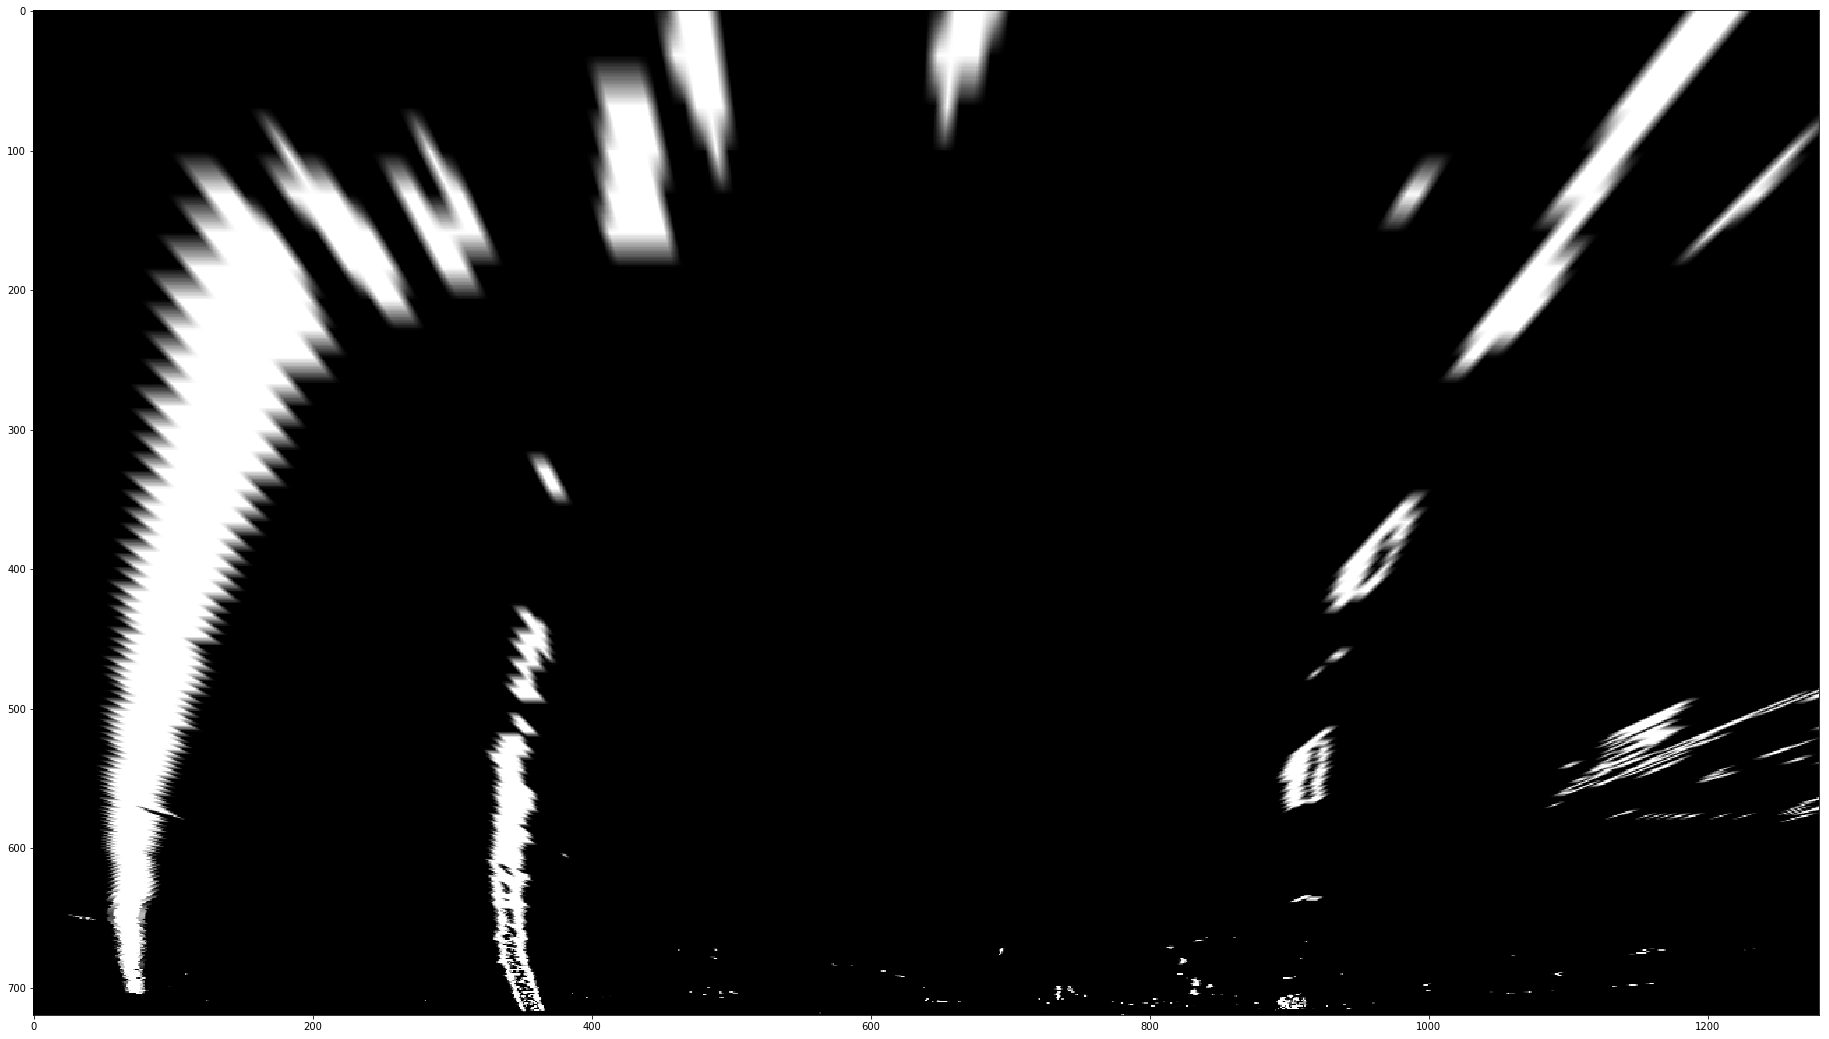

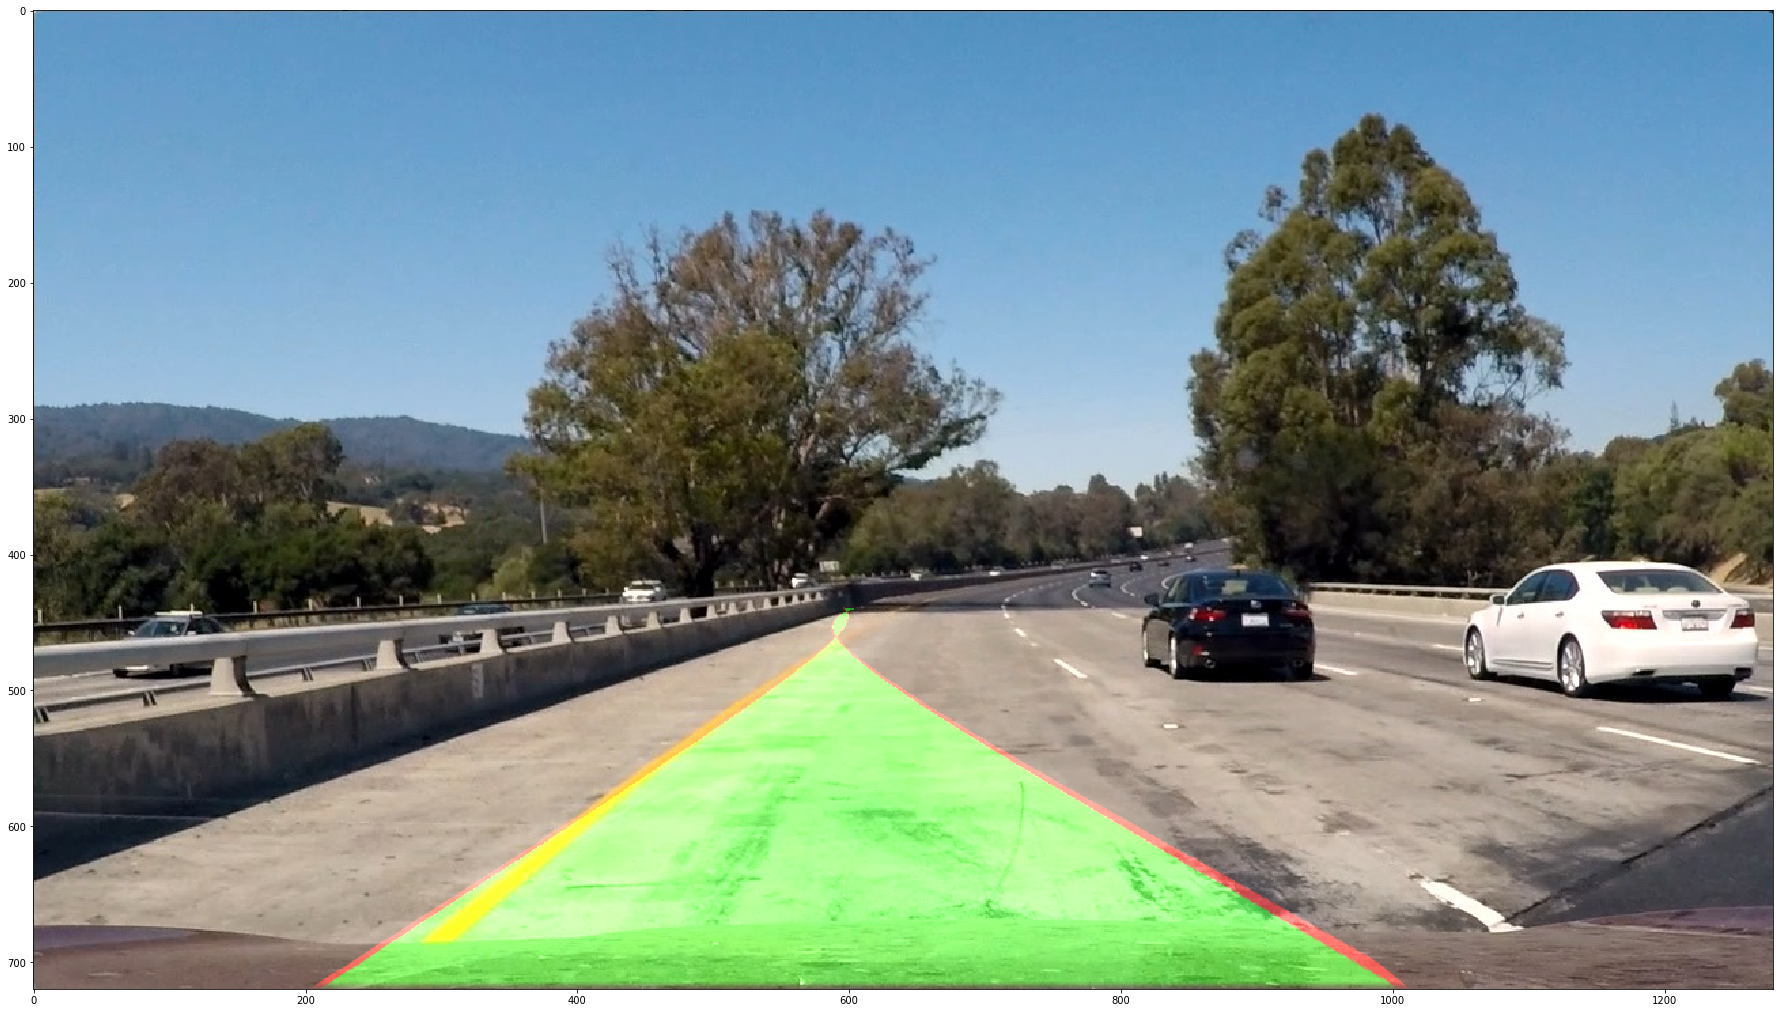

In [40]:
ld = LaneDetection(cameraMatrix, distCoeffs)

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
left_fit, right_fit, poly_left, poly_right, y, img_out = ld.detection_pipline(img)
plt.figure(figsize=(32, 18))
plt.imshow(img_out)

In [12]:
y

array([720, 685, 680, 675, 670, 665, 660, 655, 650, 645, 640, 635, 630,
       625, 620, 615, 610, 605, 600, 595, 590, 585, 580, 575, 570, 565,
       560, 555, 550, 545, 540, 535, 530, 525, 520, 515, 510, 505, 500,
       495, 490, 485, 480, 475, 470, 465, 460, 455, 450, 445, 440, 435,
       430, 425, 420, 415, 410, 405, 400, 395, 390, 385, 380, 375, 370,
       365, 360, 355, 350, 345, 340, 335, 330, 325, 320, 315, 310, 305,
       300, 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245, 240,
       235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175,
       170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110,
       105, 100,  95,  90,  85,  80,  75,  70,  65,  60,  55,  50,  45,
        40,  35])